# Computer Vision: Plant Seedlings Classification

## Problem Statement


### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [1]:
# @title
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
# !pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==2.0.3 opencv-python==4.8.0.76 -q --user

In [2]:
# Installing the libraries with the specified version.
# uncomment and run the following lines if Jupyter Notebook is being used
#!pip install tensorflow==2.13.0 scikit-learn==1.2.2 seaborn==0.11.1 matplotlib==3.3.4 numpy==1.24.3 pandas==1.5.2 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
import random

import seaborn as sns


# Tensorflow modules
import tensorflow as tf
from tensorflow import keras
from keras import callbacks
from keras import backend
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay,
    classification_report
)
#Importing cv2_imshow for displaying images
from google.colab.patches import cv2_imshow

# Library to avoid the warnings
import warnings

warnings.filterwarnings("ignore")

from typing import Tuple, List
from IPython.display import display

pd.options.display.float_format = "{:.2f}".format
pd.options.display.max_columns = None
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 400
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

## Loading the dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

# Load the labels file of dataset
y_labels = pd.read_csv('/content/drive/MyDrive/Projects/Plant_Seedlings_CVNN/Labels.csv')

# Load the image file of dataset
images_og = np.load('/content/drive/MyDrive/Projects/Plant_Seedlings_CVNN/images.npy')


Mounted at /content/drive/


## Data Overview

### Understand the shape of the dataset

In [5]:
print('Shape of images:',images_og.shape,'Shape of labels:', y_labels.shape)

Shape of images: (4750, 128, 128, 3) Shape of labels: (4750, 1)


## Exploratory Data Analysis

### Utility class for plots and conversions

In [6]:
class DataUtility:
    def __init__(self, df, label_column):
        self.df = df
        self.label_column = label_column

    def plot_class_distribution(self, figsize=(12, 6), palette="coolwarm", rotation=45):
        sns.set(style="whitegrid")
        color_palette = sns.color_palette(palette)

        # Get the counts of each class and sort them in descending order
        class_counts = self.df[self.label_column].value_counts().sort_values(ascending=False)

        # Reorder the DataFrame based on the sorted class counts
        sorted_df = self.df[self.df[self.label_column].isin(class_counts.index)]
        sorted_df[self.label_column] = pd.Categorical(sorted_df[self.label_column], categories=class_counts.index, ordered=True)
        sorted_df = sorted_df.sort_values(self.label_column)

        plt.figure(figsize=figsize)
        ax = sns.countplot(x=sorted_df[self.label_column], palette=color_palette, order=class_counts.index)

        plt.xticks(rotation=rotation, ha='right')

        plt.title('Class Distribution', fontsize=16, fontweight='bold')
        plt.xlabel('Classes', fontsize=14)
        plt.ylabel('Count', fontsize=14)

        plt.grid(axis='y', linestyle='-', alpha=0.9)

        for p in ax.patches:
            ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.4, p.get_height()), ha='center', va='center', fontsize=12, color='black', rotation=0, xytext=(0, 12), textcoords='offset points')

        plt.tight_layout()
        plt.show()

    def plot_images(self, images, num_classes=12, rows=3, cols=4, figsize=(12, 12)):
        unique_labels = np.unique(self.df[self.label_column])
        label_dict = {label: idx for idx, label in enumerate(unique_labels)}

        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = axes.flatten()

        for i, (label, ax) in enumerate(zip(unique_labels, axes)):
            label_index = self.df[self.df[self.label_column] == label].index[0]
            ax.imshow(images[label_index, :])
            ax.set_title(label)
            ax.axis('off')

        plt.tight_layout()
        plt.show()


    def preprocess_images(self, trainingset, lower=(25, 40, 50), upper=(75, 255, 255), new_img_size=(64, 64), plot_imgs=True):
        processed_imgs = []

        for i in trainingset:

            # Apply Gaussian Blur
            blurr = cv2.GaussianBlur(i, (5, 5), 0)

            # Convert BGR to HSV
            hsv = cv2.cvtColor(blurr, cv2.COLOR_BGR2HSV)

            # Mask based on HSV range
            mask = cv2.inRange(hsv, lower, upper)

            # Apply mask
            struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, struc)
            boolean = mask > 0

            # New image using the mask
            new_img = np.zeros_like(i, np.uint8)
            new_img[boolean] = i[boolean]

            # Resize the image
            resized_image = cv2.resize(new_img, new_img_size, interpolation=cv2.INTER_LINEAR)

            processed_imgs.append(resized_image)

            # Display images
            if plot_imgs:
                plt.subplot(2, 3, 1); plt.imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB)); plt.title('Original'); plt.axis('off')
                plt.subplot(2, 3, 2); plt.imshow(cv2.cvtColor(blurr, cv2.COLOR_BGR2RGB)); plt.title('Blurred'); plt.axis('off')
                plt.subplot(2, 3, 3); plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)); plt.title('HSV'); plt.axis('off')
                plt.subplot(2, 3, 4); plt.imshow(mask, cmap='gray'); plt.title('Mask'); plt.axis('off')
                plt.subplot(2, 3, 5); plt.imshow(boolean, cmap='gray'); plt.title('Boolean Mask'); plt.axis('off')
                plt.subplot(2, 3, 6); plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)); plt.title('Processed'); plt.axis('off')
                plt.show()
                plot_imgs = False

        processed_imgs = np.asarray(processed_imgs)
        return processed_imgs


### Checking the distribution and plotting images for each class

In [7]:
#Instatiate the DataUtility
data_util = DataUtility(y_labels, 'Label')

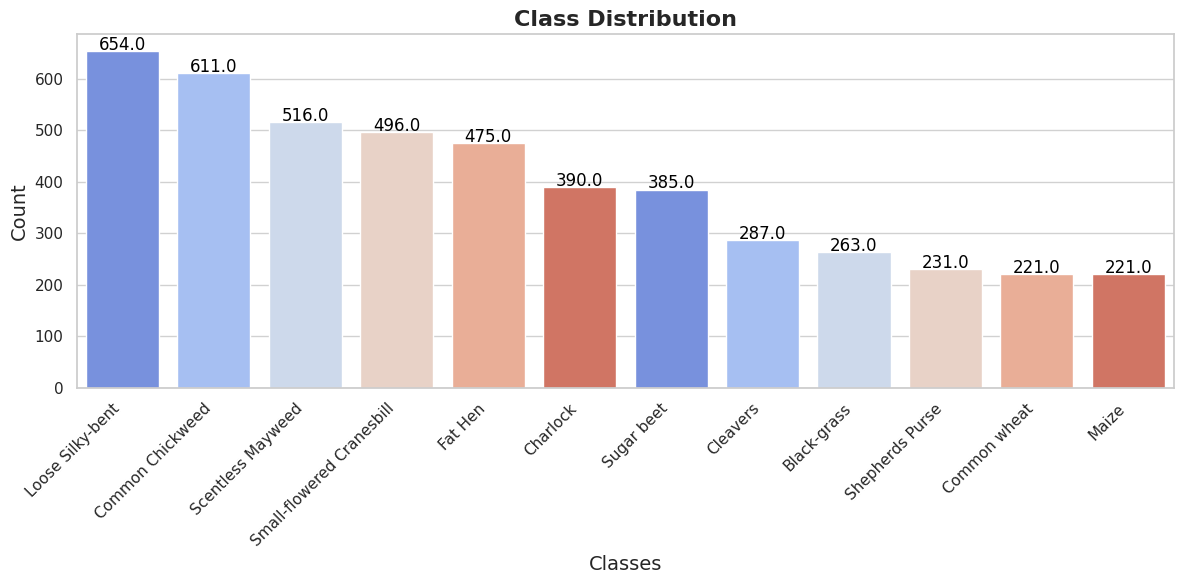

In [8]:
data_util.plot_class_distribution()

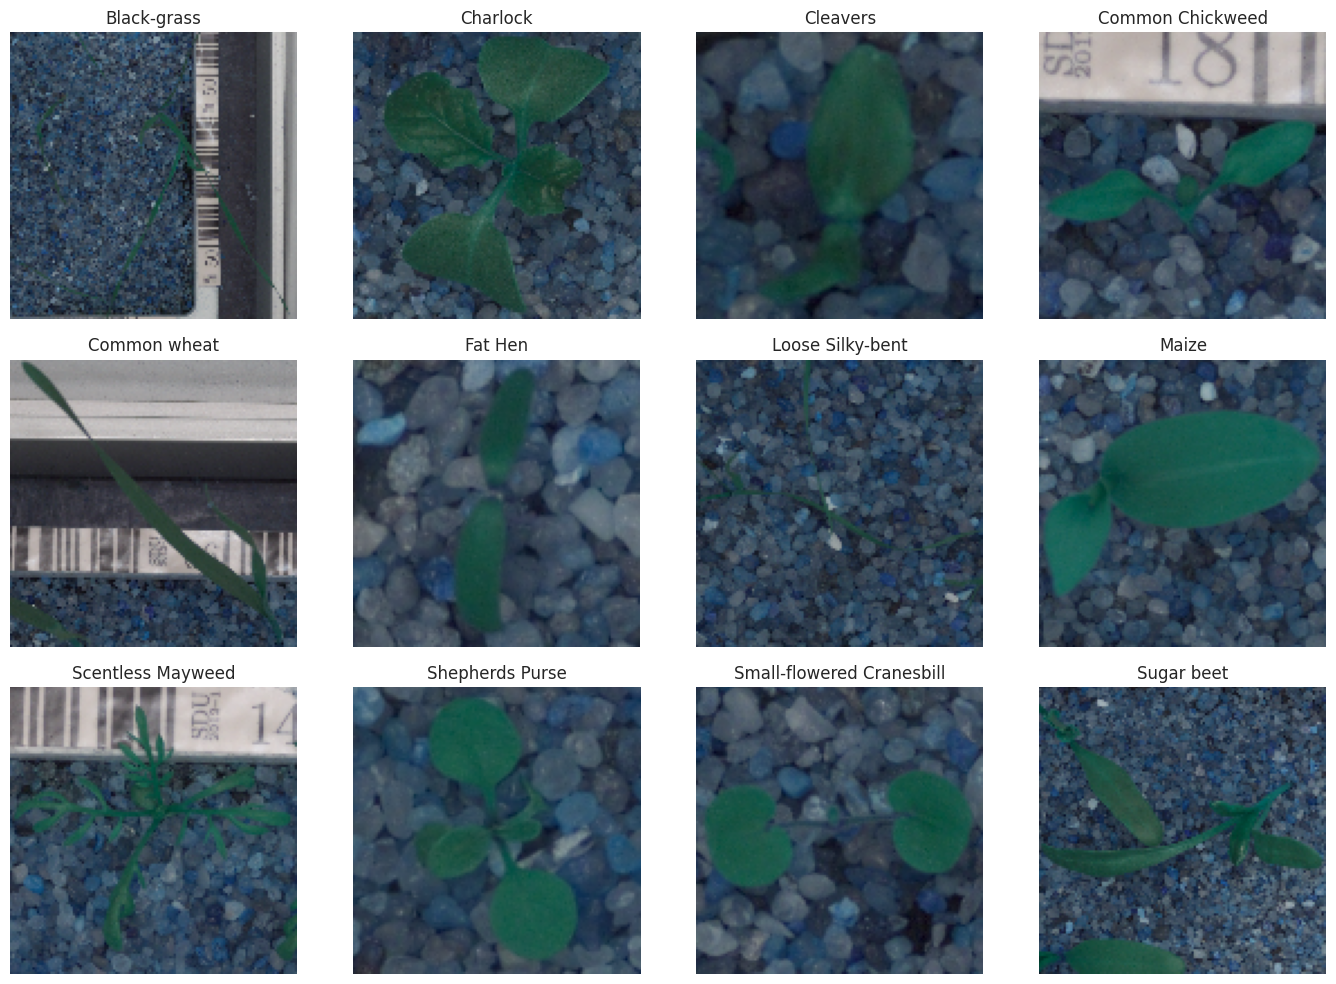

In [9]:
data_util.plot_images(images_og, num_classes=12, rows=3, cols=4, figsize=(14, 10))

**Observations**

- There are 12 plant categories
- The dataset contains 4,750 plant images.
- Each image has dimensions of 128 x 128 pixels.We will need to convert to 64 X 64.
- Images are in BGR format.
- The dataset is imbalanced.
- Images vary in lighting and backgrounds. We will need to apply masking and possibly other techniques to enhance the visibility of the plant structure.
- The images are of small plants which makes it challenging for the model to detect and classify accurately. We will need

1. How are these different category plant images different from each other?

    Different plant categories show unique leaf shapes, sizes, and textures. Scentless Mayweed has rounded leaves, Sugar Beet has long pointed leaves, and Common Wheat has thin elongated leaves. Common Chickweed and Shepherds Purse have small, clustered leaves, while Fat Hen has broader, oval leaves. Maize features broad curving leaves, Black-grass has thin, grass-like leaves, Charlock has larger lobed leaves, and Loose Silky-bent has fine, delicate leaves. These variations are essential for accurate classification.








2. Is the dataset provided an imbalance? (Check with using bar plots)

    Yes, the dataset is imbalanced. Some classes have significantly more images than others. This imbalance can lead to a model that is biased towards the classes with more images

## Data Pre-Processing

**Cleaning Image Data**

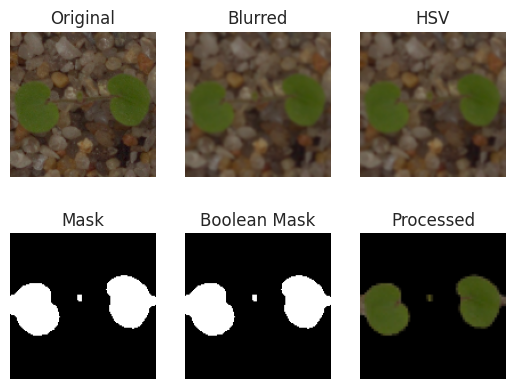

In [10]:
# Preprocess Images
images_sg = data_util.preprocess_images(images_og)

In [11]:
images_sg.shape

(4750, 64, 64, 3)

**Plot Processed Images**

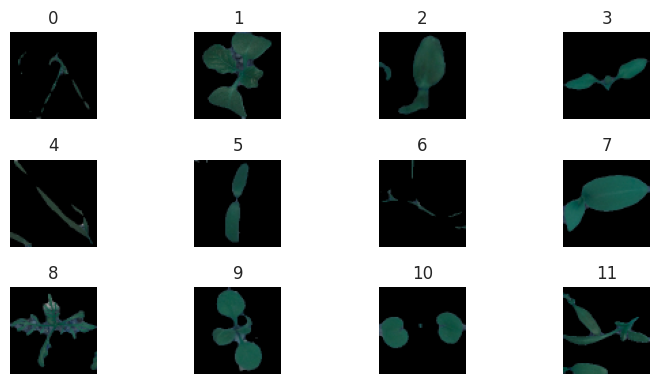

In [45]:
data_util.plot_images(images_sg, num_classes=12, rows=3, cols=4, figsize=(8, 4))

### Data Preparation for Modeling

### Encode the target labels

**One Hot Encoding**

In [13]:
y_labels['Label'] = y_labels['Label'].astype('category')
y_labels['Label'] = y_labels['Label'].cat.codes
y_labels = keras.utils.to_categorical(y_labels, num_classes=12)
print('Shape of y_labels:', y_labels.shape)
print(y_labels[0])

Shape of y_labels: (4750, 12)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


**Split the image data into train, test and validation**

In [14]:
X_temp, X_test, y_temp, y_test = train_test_split(images_sg, y_labels , test_size=0.1, random_state=42,stratify=y_labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42,stratify=y_temp)

In [15]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 12)
(428, 64, 64, 3) (428, 12)
(475, 64, 64, 3) (475, 12)


**Observations**
- The dataset is partitioned into training 3847 images, validation 428 images, and test 475 images subsets.

- All images maintain uniform dimensions of 64x64 pixels with RGB colors, which is essential for CNN input.

- Labels are encoded with 12 classes for all sets

- Consistent label dimensions

- Each set represents all 12 classes.

### Data Normalization

To standardize our image pixel values, we'll scale them by dividing by 255, adjusting the range from 0-255 to 0-1.

In [16]:
X_train = X_train.astype('float32')/255.0
X_val = X_val.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

## Model Building - Convolutional Neural Network (CNN)

###**Model 1**

To ensure consistent results in Keras, we clear the model's history and reset the seed for Numpy, Python's Random library, and TensorFlow to guarantee reproducibility.

In [17]:
def clear_backend_and_seed(seed=42):
    # Clearing backend
    backend.clear_session()

    # Fixing the seed for random number generators
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

def create_model():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2), padding = 'same'))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding = 'same'))

    model.add(Flatten())

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(12, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

def fit_model(model, X_train, y_train, X_val, y_val, epochs=30, batch_size=32, verbose=2):

    #Stops if the model is not improving
    early_stopper = callbacks.EarlyStopping(monitor='val_accuracy', patience=20, min_delta=0.0001, restore_best_weights=True)

    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        verbose=verbose,
        shuffle=True,
        callbacks = [early_stopper]
    )
    return history


def evaluate_model(model, X_test, y_test):
    #Evaluates the trained model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    return {'loss': test_loss, 'accuracy': test_accuracy}



**Clear and Seed**

In [18]:
clear_backend_and_seed(seed=42)

**Model 1 Build**

In [19]:
model1 = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

**Fitting the model on training set and use the validation data for validation**

In [20]:
# Check the input and output shapes of the model
input_shape = X_train.shape[1:]
model1.input_shape, model1.output_shape

((None, 64, 64, 3), (None, 12))

In [21]:
hist_1 = fit_model(
    model1,
    X_train,
    y_train,
    X_val,
    y_val,
    batch_size=32,
    verbose=1
)

Epoch 1/30
121/121 [==============================] - 7s 12ms/step - loss: 2.1454 - accuracy: 0.2527 - val_loss: 1.7965 - val_accuracy: 0.4019
Epoch 2/30
121/121 [==============================] - 1s 7ms/step - loss: 1.8145 - accuracy: 0.3572 - val_loss: 1.5570 - val_accuracy: 0.4626
Epoch 3/30
121/121 [==============================] - 1s 7ms/step - loss: 1.6282 - accuracy: 0.4227 - val_loss: 1.3498 - val_accuracy: 0.5467
Epoch 4/30
121/121 [==============================] - 1s 8ms/step - loss: 1.4977 - accuracy: 0.4705 - val_loss: 1.2404 - val_accuracy: 0.5981
Epoch 5/30
121/121 [==============================] - 1s 8ms/step - loss: 1.3668 - accuracy: 0.5118 - val_loss: 1.3375 - val_accuracy: 0.5678
Epoch 6/30
121/121 [==============================] - 1s 9ms/step - loss: 1.2998 - accuracy: 0.5170 - val_loss: 1.1243 - val_accuracy: 0.6285
Epoch 7/30
121/121 [==============================] - 1s 9ms/step - loss: 1.1776 - accuracy: 0.5607 - val_loss: 1.1028 - val_accuracy: 0.6449
Epoch

### **Plot Functions**

In [22]:
def plot_training_hist(history):
    # Plots the training and validation accuracy and loss
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'b', label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'b', label='Train Loss')
    plt.plot(history.history['val_loss'], 'r', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_loss(history):
    # Use a style for the plot
    plt.style.use('ggplot')

    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='Train', linewidth=2, marker='o')
    plt.plot(history.history['val_loss'], label='Validation', linewidth=2, marker='o')

    # Set a grid
    plt.grid(True, linestyle='--', alpha=0.5)

    # Set the title and labels
    plt.title('Model Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)

    # Adjust the legend
    plt.legend(loc='upper right', fontsize=10)

    # Show the plot
    plt.show()

def make_confusion_matrix(actual_targets, predicted_targets, class_labels, count=True, percent=False, title='Confusion Matrix'):
    cm = confusion_matrix(actual_targets, predicted_targets)
    cm = cm.astype('float')

    # Ensure actual_targets and predicted_targets are 1D arrays
    if isinstance(actual_targets, pd.DataFrame):
        actual_targets = actual_targets.iloc[:, 0]
    if isinstance(predicted_targets, pd.DataFrame):
        predicted_targets = predicted_targets.iloc[:, 0]

    blanks = ['' for _ in range(cm.size)]

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cm.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=box_labels, fmt="", cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



### **Model Evaluation**

**Evaluate the model on test data**


In [23]:
eval_results = evaluate_model(model1, X_test, y_test)
print(f"Test Loss: {eval_results['loss']}")
print(f"Test Accuracy: {eval_results['accuracy']}")

15/15 - 0s - loss: 1.0700 - accuracy: 0.7074 - 158ms/epoch - 11ms/step
Test Loss: 1.0699814558029175
Test Accuracy: 0.7073684334754944


**Observation**

- The test accuracy of approximately 71%, indicates moderate performance.

- The test loss is 1.12, indicating there is still room for improvement in the predictions.


**Generating the predictions on test data**

In [24]:
#Retrieve the output probabilities for each category
y_pred=model1.predict(X_test)

15/15 [==============================] - 0s 3ms/step


In [25]:
y_pred

array([[1.94235135e-08, 2.03349143e-01, 2.75633305e-01, ...,
        1.03156440e-01, 1.57941189e-02, 1.85083209e-05],
       [3.89073007e-02, 1.42854666e-02, 1.04366131e-01, ...,
        2.31043032e-05, 1.79734718e-06, 1.74630463e-01],
       [3.43175032e-07, 4.19295576e-09, 3.98527739e-10, ...,
        3.28174123e-04, 3.66285421e-05, 7.78656542e-01],
       ...,
       [1.04595884e-13, 9.09437537e-01, 4.06090952e-02, ...,
        3.56578566e-02, 1.41778532e-02, 5.20322487e-07],
       [1.72453028e-07, 6.98762836e-12, 3.45124658e-11, ...,
        1.27535823e-04, 9.99872327e-01, 2.67148104e-09],
       [5.82393786e-11, 5.76097667e-02, 3.06366235e-02, ...,
        2.02236056e-01, 8.50836746e-03, 1.04142453e-06]], dtype=float32)

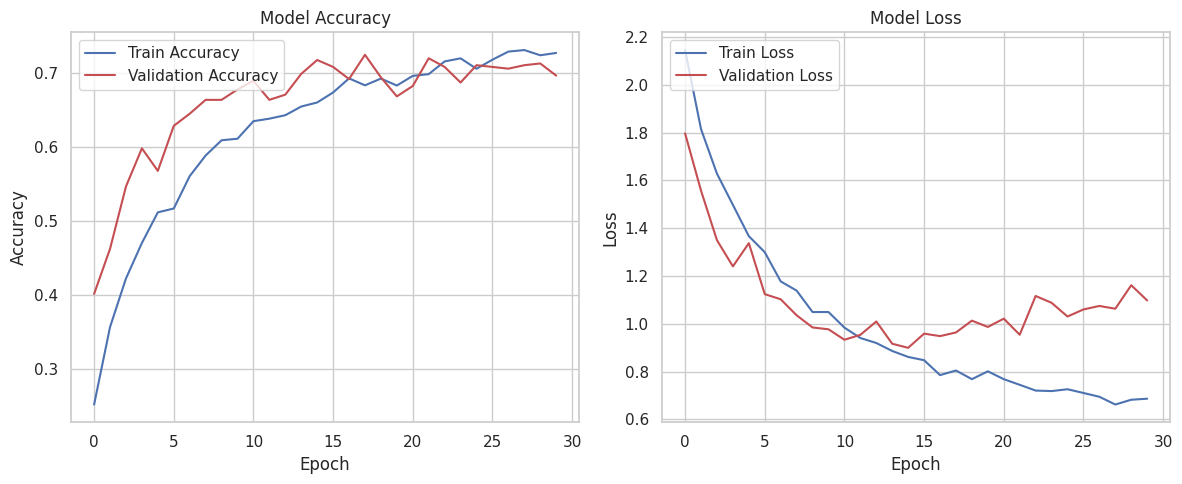

In [26]:
# Plot the training history
plot_training_hist(hist_1)

**Observations**

- Training and validation accuracy increased steadily indicating a good initial fit but slight overfitting as training later exceeds validation.

- Loss decreases sharply in the first 10 epochs, indicating good learning and stabilization after epoch 10-15.

- After epoch 20, training loss drops while validation loss plateaus and slightly rises, indicating possible overfitting.

**Plotting the Confusion Matrix**

To generate probability estimates for the test data, we use the predict method in Keras, which inherently provides these probabilities.


In [27]:
# Grabbing the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test,axis=1)

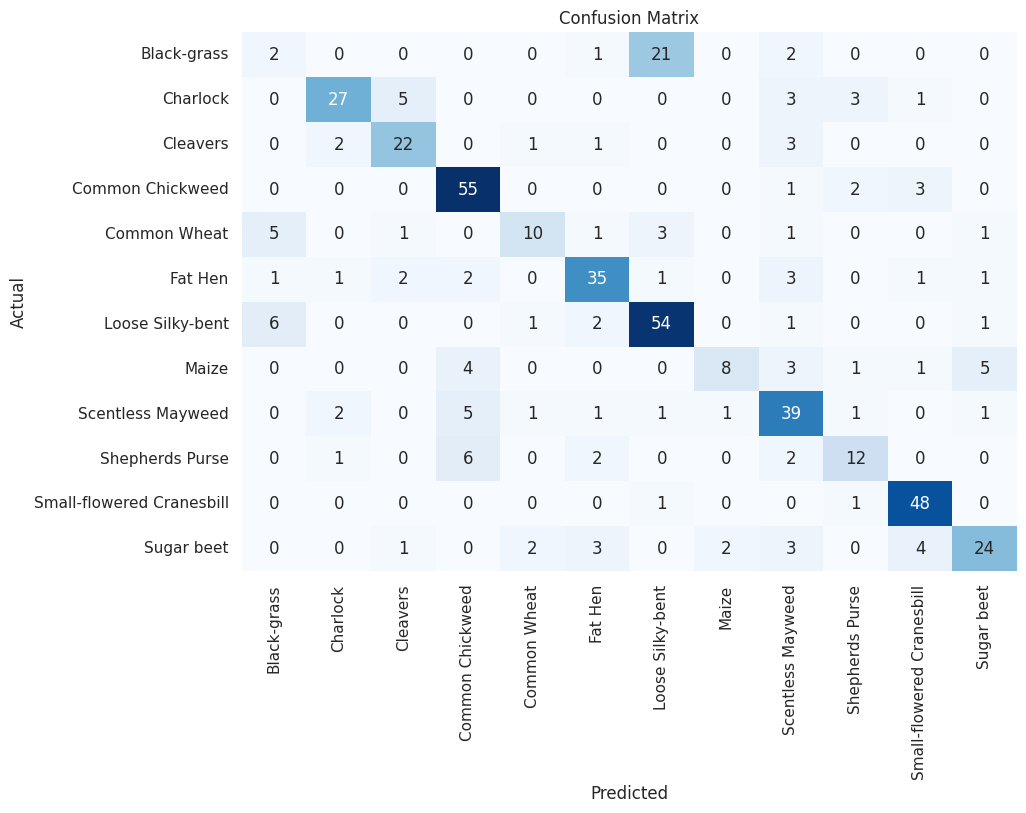

In [28]:
# Plot the Confusion Matrix
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

class_labels = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common Wheat', 'Fat Hen',
                'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

make_confusion_matrix(y_test_labels, y_pred_labels, class_labels)

**Observations**

- The model shows high accuracy for some classes but struggles with misclassifications.

**Classification Report**

In [29]:
c_report = classification_report(y_test_arg, y_pred_arg, target_names=class_labels, output_dict=True)

# Convert dictionary to DataFrame
classification_report_df = pd.DataFrame.from_dict(c_report).transpose()
classification_report_df['support'] = classification_report_df['support'].fillna(0).astype(int)
classification_report_df.loc['accuracy'] = classification_report_df.loc['accuracy'].fillna(0)
classification_report_df_sorted = classification_report_df.drop(['accuracy', 'macro avg', 'weighted avg'])
classification_report_df_sorted = classification_report_df_sorted.sort_values(by=['precision', 'recall', 'f1-score'], ascending=False)
classification_report_df_sorted = pd.concat([classification_report_df_sorted, classification_report_df.loc[['macro avg', 'weighted avg', 'accuracy']]])

# Display the DataFrame
print(classification_report_df_sorted)

                           precision  recall  f1-score  support
Small-flowered Cranesbill       0.83    0.96      0.89       50
Charlock                        0.82    0.69      0.75       39
Common Chickweed                0.76    0.90      0.83       61
Fat Hen                         0.76    0.74      0.75       47
Sugar beet                      0.73    0.62      0.67       39
Maize                           0.73    0.36      0.48       22
Cleavers                        0.71    0.76      0.73       29
Loose Silky-bent                0.67    0.83      0.74       65
Common Wheat                    0.67    0.45      0.54       22
Scentless Mayweed               0.64    0.75      0.69       52
Shepherds Purse                 0.60    0.52      0.56       23
Black-grass                     0.14    0.08      0.10       26
macro avg                       0.67    0.64      0.64      475
weighted avg                    0.69    0.71      0.69      475
accuracy                        0.71    

**Observations**

- Common Chickweed and Small-flowered Cranesbill show excellent precision, recall, and F1 scores, indicating strong classification reliability.

- Black-grass exhibits low precision and recall, suggesting challenges in its identification.

- The model achieves 71% accuracy, reflecting reasonable performance across classes.

- Class representation impacts performance, particularly affecting underrepresented classes like Black-grass and Maize.


## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [30]:
# Code to monitor val_accuracy
learn_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

### **Data Augmentation**



**Clear and Seed**

In [31]:
clear_backend_and_seed(seed=42)

**Rotate Images**

- ImageDataGenerator enhances the dataset by applying random transformations, increasing variety and helping the model generalize better.

- Random rotations, zooms, shifts, and flips simulate real-world variations, preventing overfitting and improving model robustness.



In [32]:
train_datagen = ImageDataGenerator(
    zoom_range = 0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

#### **Model 2 Build**


In [33]:
def create_model2():
    # Instantiate sequential model
    model = Sequential()

    # First Convolution Block
    model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), 2))
    model.add(Dropout(0.2))

    # Second Convolution Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), 2))
    model.add(Dropout(0.2))

    # Third Convolution Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), 2))
    model.add(Dropout(0.2))

    # Fourth Convolution Block
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), 2))
    model.add(Dropout(0.2))


    model.add(Flatten())

    # Fully connected layer, 256 neurons
    model.add(BatchNormalization())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.2))

    # Fully connected layer with 256 neurons
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # The final output layer with 12 neurons to predict the categorical classification
    model.add(Dense(12, activation='softmax'))

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

def fit_model2(model, X_train, y_train, X_val, y_val, epochs=30, batch_size=32, verbose=1):

    #Stops if the model is not improving
    # early_stopper = callbacks.EarlyStopping(monitor='val_accuracy', patience=20, min_delta=0.0001, restore_best_weights=True)

    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        verbose=verbose,
        shuffle=True,
        callbacks = [learn_reduction]
        # callbacks = [early_stopper, learn_reduction]
    )
    return history

def evaluate_model2(model, X_test, y_test):
    #Evaluates the trained model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    return {'loss': test_loss, 'accuracy': test_accuracy}

**Fitting the model on the train data**

In [34]:
model2 = create_model2()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        2

In [35]:
hist_2 = fit_model2(
    model2,
    X_train,
    y_train,
    X_val,
    y_val,
    epochs=180,
    batch_size=32,
    verbose=1
)

Epoch 1/180
121/121 [==============================] - 9s 19ms/step - loss: 1.5528 - accuracy: 0.4747 - val_loss: 9.3692 - val_accuracy: 0.0607 - lr: 0.0010
Epoch 2/180
121/121 [==============================] - 2s 13ms/step - loss: 0.9855 - accuracy: 0.6618 - val_loss: 11.1758 - val_accuracy: 0.0607 - lr: 0.0010
Epoch 3/180
121/121 [==============================] - 2s 13ms/step - loss: 0.7921 - accuracy: 0.7216 - val_loss: 7.8741 - val_accuracy: 0.0607 - lr: 0.0010
Epoch 4/180
121/121 [==============================] - ETA: 0s - loss: 0.6314 - accuracy: 0.7806
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
121/121 [==============================] - 2s 13ms/step - loss: 0.6314 - accuracy: 0.7806 - val_loss: 6.7701 - val_accuracy: 0.0607 - lr: 0.0010
Epoch 5/180
121/121 [==============================] - 2s 14ms/step - loss: 0.5313 - accuracy: 0.8087 - val_loss: 6.3482 - val_accuracy: 0.0841 - lr: 5.0000e-04
Epoch 6/180
121/121 [============================

**Model Evaluation**

In [36]:
eval_results2 = evaluate_model2(model2, X_test, y_test)
print(f"Test Loss: {eval_results2['loss']}")
print(f"Test Accuracy: {eval_results2['accuracy']}")

15/15 - 0s - loss: 0.5882 - accuracy: 0.8442 - 238ms/epoch - 16ms/step
Test Loss: 0.5881690382957458
Test Accuracy: 0.8442105054855347


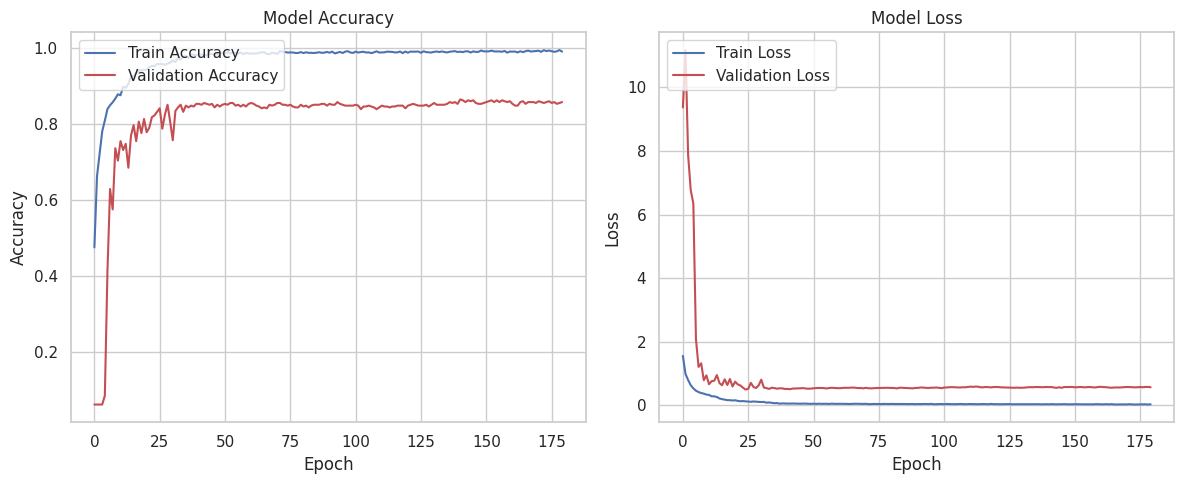

In [37]:
# Plot the training history
plot_training_hist(hist_2)

**Observations**
- Training accuracy is in high 90's, indicating strong learning but potential overfitting.

- Validation accuracy stabilizes around 80%, showing good but improvable generalization.

- Training loss remains low and steady, confirming effective learning on training data.

- Validation loss stabilizes after initial fluctuations, suggesting improved model stability and consistent performance.

**Evaluate the model on test data**

In [38]:
accuracy2 = model2.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy2[1]}")

15/15 [==============================] - 0s 6ms/step - loss: 0.5882 - accuracy: 0.8442
Test Accuracy: 0.8442105054855347


**Plot the Confusion Matrix**

In [39]:
y_pred = model2.predict(X_test)

15/15 [==============================] - 0s 4ms/step


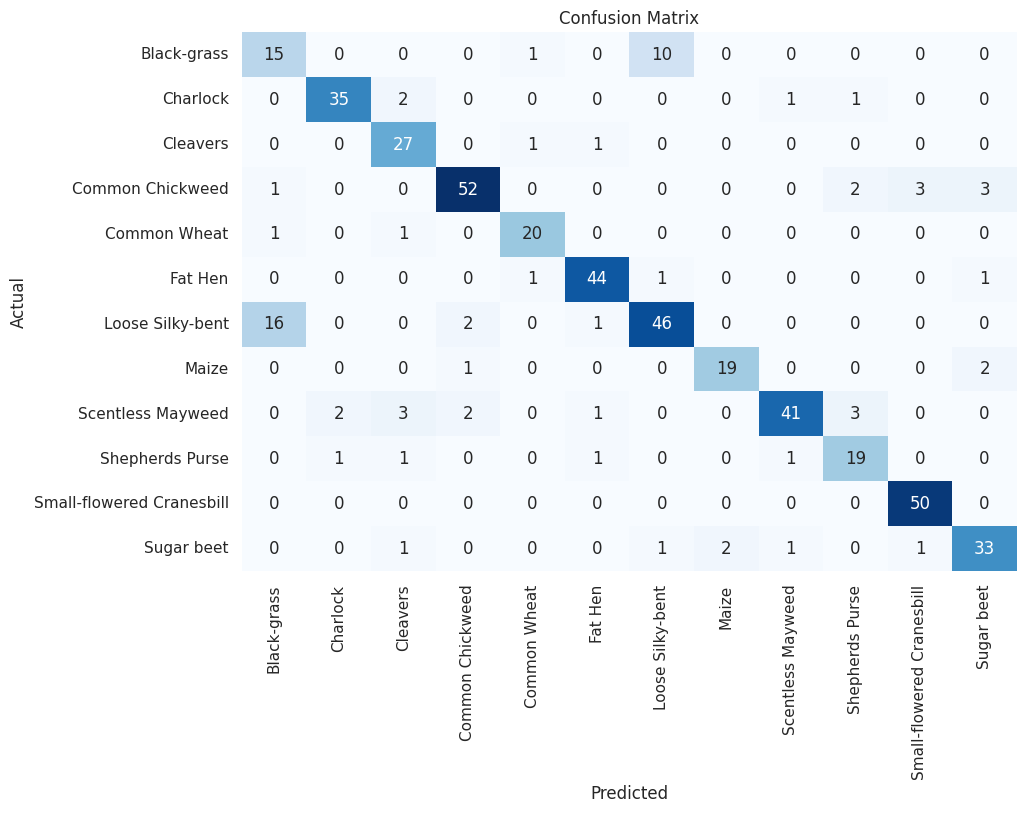

In [40]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test,axis=1)

class_labels = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common Wheat', 'Fat Hen',
                'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

make_confusion_matrix(y_test_arg, y_pred_arg, class_labels)

**Observations**

- Loose Silky-bent is frequently misclassified as Black-grass, indicating confusion between these two classes.

- Common Chickweed is mostly correctly classified with minor misclassifications, showing strong model performance for this class.

- Scentless Mayweed and Cleavers exhibit notable misclassification, suggesting these classes need better differentiation.

- Most classes have a high diagonal count, indicating accurate predictions overall, but specific pairs show confusion needing further attention.

**Plotting Classification Report**

In [41]:
c2_report = classification_report(y_test_arg, y_pred_arg, target_names=class_labels, output_dict=True)

# Convert dictionary to DataFrame
classification_report_df = pd.DataFrame.from_dict(c2_report).transpose()
classification_report_df['support'] = classification_report_df['support'].fillna(0).astype(int)
classification_report_df.loc['accuracy'] = classification_report_df.loc['accuracy'].fillna(0)
classification_report_df_sorted = classification_report_df.drop(['accuracy', 'macro avg', 'weighted avg'])
classification_report_df_sorted = classification_report_df_sorted.sort_values(by=['precision', 'recall', 'f1-score'], ascending=False)
classification_report_df_sorted = pd.concat([classification_report_df_sorted, classification_report_df.loc[['macro avg', 'weighted avg', 'accuracy']]])

# Display the DataFrame
print(classification_report_df_sorted)

                           precision  recall  f1-score  support
Scentless Mayweed               0.93    0.79      0.85       52
Small-flowered Cranesbill       0.93    1.00      0.96       50
Charlock                        0.92    0.90      0.91       39
Fat Hen                         0.92    0.94      0.93       47
Common Chickweed                0.91    0.85      0.88       61
Maize                           0.90    0.86      0.88       22
Common Wheat                    0.87    0.91      0.89       22
Sugar beet                      0.85    0.85      0.85       39
Loose Silky-bent                0.79    0.71      0.75       65
Cleavers                        0.77    0.93      0.84       29
Shepherds Purse                 0.76    0.83      0.79       23
Black-grass                     0.45    0.58      0.51       26
macro avg                       0.83    0.84      0.84      475
weighted avg                    0.85    0.84      0.85      475
accuracy                        0.84    

**Observations**

- Scentless Mayweed shows high precision but lower recall, indicating missed instances in predictions.

- Common Chickweed and Small-flowered Cranesbill have high f1-scores, showing strong classification reliability.

- Black-grass has the lowest f1-score, which is where the difficulty in correctly identifying lies.

- The overall accuracy is 83%, indicating a reasonable model performance across the 12 classes.

## Conclusion

We've developed a Convolutional Neural Network [CNN] model to classify plant species and shows promising performance. By fine-tuning hyperparameters, such as increasing epochs or adding layers, we can enhance its accuracy and robustness of the model.

Combining Batch Normalization, Max Pooling, Dropout, and Dense Layers improves performance and ensures good generalization to unseen data.

Methods used to optimize performance:

1. Batch Normalization normalizes inputs of each layer, accelerating training and improving stability, while also mitigating overfitting by providing a regularizing effect.

2. Max Pooling reduces spatial dimensions of feature maps, reducing computational load and controlling overfitting, retaining important features while discarding less significant information.

3. Dropout randomly deactivates neurons during training to prevent the model from relying on specific neurons, enhancing generalization.

4. Dense fully connected layers at the end of the network combine features extracted by convolutional layers for final classification, crucial for learning complex representations and making accurate predictions.

5. Adam Optimizer an adaptive optimization algorithm that adjusts learning rates for each parameter, incorporates momentum to accelerate convergence, and includes bias correction, leading to efficient and effective training of neural networks.


## Final Model

- Final Model Evaluation:
The final model demonstrates promising performance with an overall accuracy of 0.83 and a weighted average F1-score of 0.83. However, there are still areas for improvement, particularly in classifications between similar classes such as Black-grass, Common Wheat, and Scentless Mayweed.




### Visualizing the prediction

In [42]:
# Initialize the label encoder with the class labels
enc = LabelEncoder()
enc.fit(class_labels)

def visualize_and_predict(model, X_test, y_test, index, encoder, scale_factor=2):
    # Display the image using OpenCV
    img = X_test[index]

    height, width = img.shape[:2]
    new_dimensions = (int(width * scale_factor), int(height * scale_factor))
    resized_img = cv2.resize(img, new_dimensions, interpolation=cv2.INTER_LINEAR)

    cv2_imshow(resized_img)
    print(f"\n")


    prediction = model.predict(X_test[index].reshape(1, 64, 64, 3))
    predicted_label = encoder.inverse_transform(np.argmax(prediction, axis=1))
    true_label = encoder.inverse_transform([np.argmax(y_test[index])])

    print(f"\n{'-'*40}")
    print(f"Predicted Label: {predicted_label[0]}")
    print(f"True Label: {true_label[0]}")
    print(f"{'-'*40}\n")

def visualize_and_predict_multiple(model, X_test, y_test, indices, encoder):
    for index in indices:
        visualize_and_predict(model, X_test,  y_test, index, encoder)

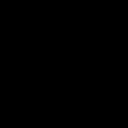



1/1 [==============================] - 0s 329ms/step

----------------------------------------
Predicted Label: Fat Hen
True Label: Fat Hen
----------------------------------------



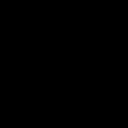



1/1 [==============================] - 0s 29ms/step

----------------------------------------
Predicted Label: Charlock
True Label: Charlock
----------------------------------------



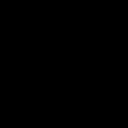



1/1 [==============================] - 0s 35ms/step

----------------------------------------
Predicted Label: Small-flowered Cranesbill
True Label: Small-flowered Cranesbill
----------------------------------------



In [43]:
indices_to_visualize = [2, 7, 11]
visualize_and_predict_multiple(model2, X_test, y_test, indices_to_visualize, enc)

## Actionable Insights and Business Recommendations

- Improve models with varied filter sizes and counts.

- Train on original 128x128 images instead of downsizing.

- Boost performance via increased Data Augmentation and adjusted dropout rates.

- Utilize alternative Transfer Learning architectures for enhanced classification.

- Make sure that the data collection for underprivileged categories such as Blackgrass improves model performance and reduces misclassifications.

- Apply enhanced data enrichment to make it more generalized and less over-fitted by increasing variations in training data.

- Resource allocation for improving classification of difficult classes, like black grass, using synthetic data or feature engineering.

- Regulate the hyperparameters of the models based on regular monitoring of its performances to ensure optimal results and avoid overfitting.

- Confirm the models predicted outcomes by conducting field tests in farming environments for practicality purposes.

- Precise agriculture tools need to be developed and have this model combined with them so that plant identification could be automated hence time saved as well as reduced labor costs.

- Implement continuous learning into the model so that it can adapt to environmental changes and seasonality through updating it with new data.



_____